In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [56]:
import tensorflow as tf
from tensorflow.keras import layers, models

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

## Note:

The cell below was modified to ensure that the image paths were appropriately pointed to

In [14]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    folder_path = "/Users/swzhao/Desktop/Columbia/Applied Data Science/Project 2 - Weakly Supervised learning/"
    img_fn = f'data/images/{i+1:05d}.png'
    img_fn = folder_path + img_fn
    
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt(folder_path+'data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt(folder_path +'data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


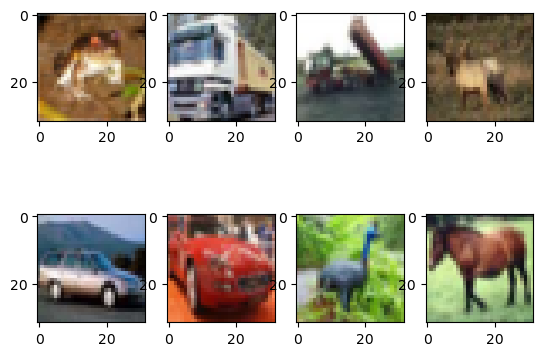

In [15]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [16]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [17]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [18]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

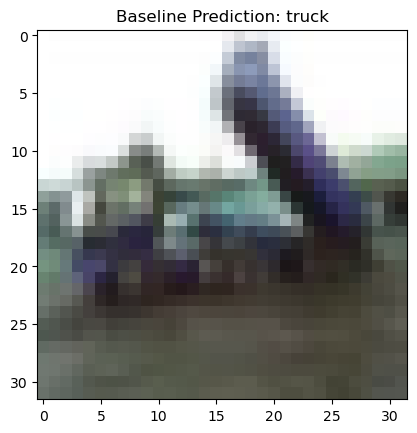

In [48]:
# Example
img = cv2.imread(folder_path+'data/images/00003.png')

plt.imshow(img)
plt.title("Baseline Prediction: " + str(classes[int(baseline_model(img))]))
plt.show()

### 2.2. Model I

In [68]:
# Convolution model
model = models.Sequential()
input_shape = (32, 32, 3)  # Input shape of the image
num_classes = 10  # Number of output classes (0-9 inclusive)

# # layers
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# # Flatten the output for Dense layers
# model.add(layers.Flatten())

# # dense layers
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer with softmax activation for classification

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for Dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))  

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [69]:
model

In [70]:
x_train = imgs  # all images
x_test = imgs[:10000, :, : , :]  # first 10000 clean images

y_train = noisy_labels # train on all noisy labels
y_test = clean_labels #clean labels for first 10000 images

In [71]:
# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/10
1563/1563 [==============================] - 60s 38ms/step - loss: 2.3094 - accuracy: 0.1262 - val_loss: 2.2075 - val_accuracy: 0.2527
Epoch 2/10
1563/1563 [==============================] - 61s 39ms/step - loss: 2.2722 - accuracy: 0.1493 - val_loss: 2.0951 - val_accuracy: 0.3153
Epoch 3/10
1563/1563 [==============================] - 58s 37ms/step - loss: 2.2628 - accuracy: 0.1617 - val_loss: 2.0791 - val_accuracy: 0.3467
Epoch 4/10
1563/1563 [==============================] - 60s 39ms/step - loss: 2.2565 - accuracy: 0.1699 - val_loss: 2.0969 - val_accuracy: 0.3266
Epoch 5/10
1563/1563 [==============================] - 58s 37ms/step - loss: 2.2480 - accuracy: 0.1825 - val_loss: 2.0626 - val_accuracy: 0.3585
Epoch 6/10
1563/1563 [==============================] - 57s 37ms/step - loss: 2.2436 - accuracy: 0.1850 - val_loss: 1.9430 - val_accuracy: 0.3976
Epoch 7/10
1563/1563 [==============================] - 57s 37ms/step - loss: 2.2372 - accuracy: 0.1923 - val_loss: 1.9523 -

In [72]:
model.save("Model 1")

2024-03-18 01:49:28.483712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2024-03-18 01:49:28.593786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: Model 1/assets


INFO:tensorflow:Assets written to: Model 1/assets


In [112]:
# Treats noisy labels as clean labels and does not differentiate between the two
# Input : (32, 32, 3) (32x32 pixels, 3 RGB channel) image
# Output : Numerical classification label [0-9] 
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    img_data = np.zeros((1, 32, 32, 3))
    img_data[0] = image
    probs = model.predict(img_data[:1, :, :, :])
    return np.argmax(probs)

1/1 [==============================] - 0s 14ms/step


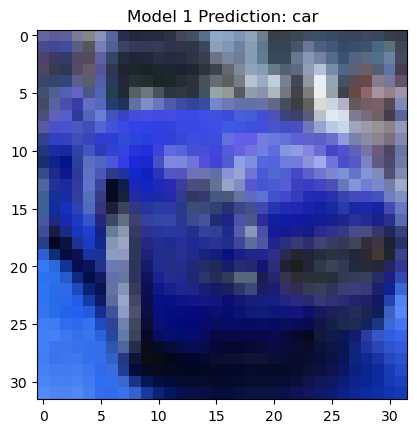

In [118]:
# Example
img = cv2.imread(folder_path+'data/images/00006.png')

plt.imshow(img)
plt.title("Model 1 Prediction: " + str(classes[int(model_I(img))]))
plt.show()

### 2.3. Model II

In [8]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [24]:
import csv

In [27]:
# split portion of clean labels to serve validation purpose

source_file = folder_path + 'data/clean_labels.csv'
destination_file = folder_path + 'data/test_labels.csv'

# Open the source CSV file for reading
with open(source_file, 'r', newline='') as source_csv_file:
    reader = csv.reader(source_csv_file)
    data = list(reader)

# write first 1000 lines into validation labels
# Open the destination CSV file for writing
with open(destination_file, 'w', newline='') as destination_csv_file:
    writer = csv.writer(destination_csv_file)
    # Write each row from the source CSV file to the destination CSV file
    i = 0
    for row in data:
        writer.writerow(row)
        i+=1
        if i > 1000:
            break


In [26]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [32]:
# [DO NOT MODIFY THIS CELL]
# NOTE: modified cell for pathnames
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt(folder_path+'data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    #img_fn = f'data/test_images/test{i+1:05d}.png'
    img_fn = f'data/images/{i+1:05d}.png'
    img_fn = folder_path + img_fn
    
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

ValueError: Found input variables with inconsistent numbers of samples: [1001, 10000]

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.